#Installing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
#from tensorflow.keras.metrics import SparseCategoricalAccuracy
#from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

#Importing Data

I had downloaded the .xlsx file from the link and uploaded it here.

In [2]:
xls = pd.read_excel('/content/ML Assignment Dataset.xlsx', sheet_name=['Train', 'Test'])
df = xls['Train']

#Exploratory Data Analysis

An open ended EDA to explore the data set and extract few insights from it.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8588 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8589 non-null   object
dtypes: object(3)
memory usage: 201.4+ KB


In [4]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

Text(0.5, 1.0, 'Product Type')

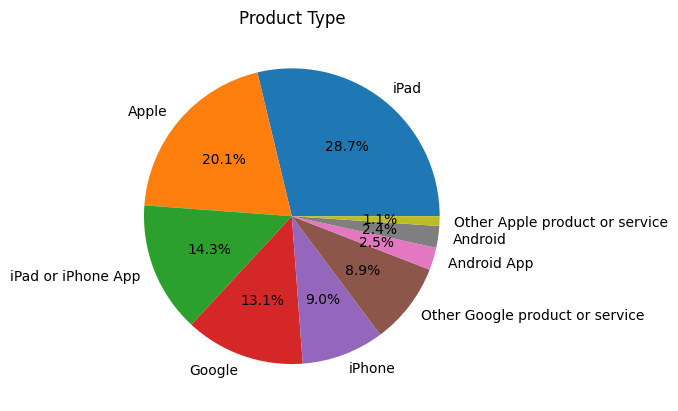

In [5]:
chart_values = df['emotion_in_tweet_is_directed_at'].value_counts()
chart_values.plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.title('Product Type')

In [6]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2672
Negative emotion                       519
I can't tell                             9
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

Text(0.5, 1.0, 'Emotion of the Tweets')

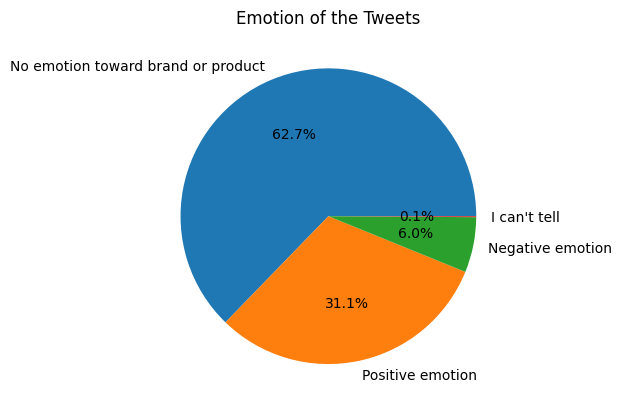

In [7]:
chart_values = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
chart_values.plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.title('Emotion of the Tweets')

In [8]:
df['emotion_in_tweet_is_directed_at'].value_counts().head()

iPad                  946
Apple                 661
iPad or iPhone App    470
Google                430
iPhone                297
Name: emotion_in_tweet_is_directed_at, dtype: int64

Seems like the most talked products are from the Company Apple.

Text(0.5, 1.0, 'Emotion of the Tweets related to iPAD')

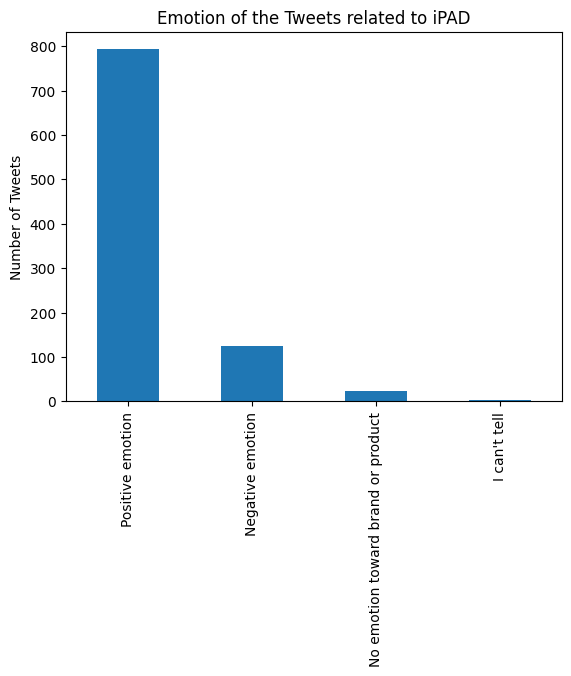

In [9]:
chart_values = df[df['emotion_in_tweet_is_directed_at'] == 'iPad']['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
chart_values.plot.bar()
plt.ylabel('Number of Tweets')
plt.title('Emotion of the Tweets related to iPAD')

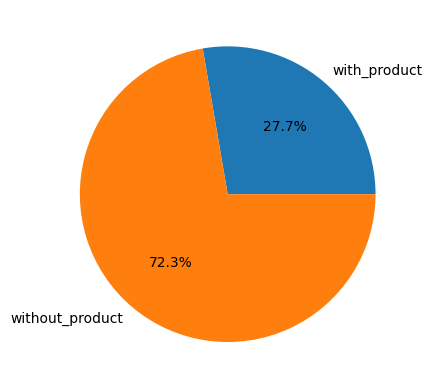

In [10]:
numbers = [3291, 8588]
labels = ['with_product', 'without_product']
plt.pie(numbers, labels=labels, autopct='%1.1f%%');

As evident from above almost 72.3% of the tweets are not targetted towards any product.

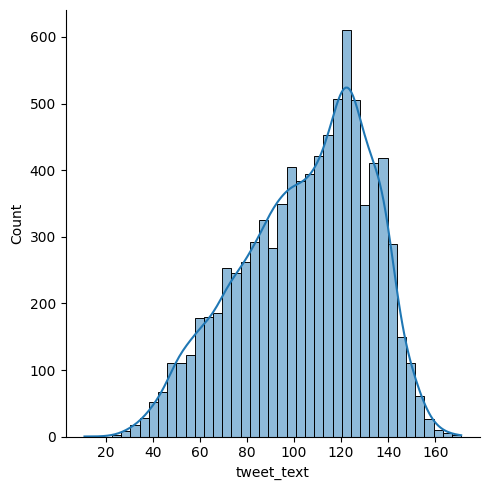

In [11]:
sns.displot(df['tweet_text'].str.len(),kde=True);

#Data Cleaning

## 1. Lowercasing

In [12]:
df['tweet_text']=df['tweet_text'].astype(str)
df['tweet_text'] = df['tweet_text'].str.lower()

## 2. Removing Non Alpha Numerics from the tweets.

In [13]:
df['tweet_text']=df['tweet_text'].apply(lambda x:re.sub(r'[^a-z]+',' ',x))

## 3. Removing Hyperlinks or URLs

In [14]:
df['tweet_text']=df['tweet_text'].apply(lambda x:re.sub('http[s]?://\S+',' ', x))

## 4. Final check on some samples

In [15]:
df['tweet_text'].sample(10)

528     i have to go to sxsw next year rt mention appl...
3191     technology apple heads to sxsw sets up tempor...
4618    fantastico rt mention marissa mayer google wil...
2193    game logic agency behaviour monkey mind contro...
1217    apple has two austin area retail locations but...
5992    rt mention need a workspace book it from your ...
1060     mention sxsw official iphone app here link en...
7935    now more than lined up for sxsw apple pop up s...
1753    there is a tech bro posed as a homeless person...
4709    are you going to sxsw in austin and want to wi...
Name: tweet_text, dtype: object

# Model Building

### Text Classification model, for finding where the tweet is directed at.

In [16]:
condition = df['emotion_in_tweet_is_directed_at'].notna()
tc_df = df.loc[condition, ['tweet_text', 'emotion_in_tweet_is_directed_at']]

Seperated the rows which have non null values in the product column.

In [17]:
tc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 0 to 8584
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   tweet_text                       3291 non-null   object
 1   emotion_in_tweet_is_directed_at  3291 non-null   object
dtypes: object(2)
memory usage: 77.1+ KB


In [18]:
tc_df['emotion_in_tweet_is_directed_at'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

Manually labelling every category of products column as category number is small, otherwise label encoder from sklearn can be used.

In [19]:
category_mapping = {'iPhone' :0, 'iPad or iPhone App': 1 , 'iPad': 2 , 'Google': 3, 'Android': 4,
       'Apple': 5 , 'Android App': 6 , 'Other Google product or service': 7,
       'Other Apple product or service': 8 }

reverse_mapping = {v: k for k, v in category_mapping.items()}
tc_df['Label'] = df['emotion_in_tweet_is_directed_at'].map(category_mapping)

Creating Train and Validation dataset

In [20]:
texts = tc_df['tweet_text'].tolist()
labels = tc_df['Label'].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

Preparing Input and Outout tensors for the model.

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9) #9 Categories

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
train_tokens = tokenizer(train_texts, padding=True, truncation=True, return_tensors='tf')
train_labels = tf.convert_to_tensor(np.array(train_labels, dtype=np.int32), dtype=tf.int32)

val_tokens = tokenizer(val_texts, padding=True, truncation=True, return_tensors='tf')
val_labels = tf.convert_to_tensor(np.array(val_labels, dtype=np.int32), dtype=tf.int32)

Now the input data is ready, we will now compile the model for the BERT model which was downloaded before.

In [23]:
# Build the model using the functional API
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids'),
    tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask'),
    model,
    tf.keras.layers.Dense(9, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 attention_mask (InputLayer  multiple                  0         
 )                                                               
                                                                 
 tf_bert_for_sequence_class  TFSequenceClassifierOut   109489161 
 ification (TFBertForSequen  put(loss=None, logits=(             
 ceClassification)           None, 9),                           
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 dense (Dense)               (None, 9)                 90        
                                                                 
Total params: 109489251 (417.67 MB)
Trainable params: 109489251 (417.67 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [24]:
model.fit(
    {'input_ids': train_tokens['input_ids'], 'attention_mask': train_tokens['attention_mask']},
    train_labels,
    epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['attention_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


83/83 [==============================] - 79s 299ms/step - loss: 1.9665 - accuracy: 0.2610
Epoch 2/10
83/83 [==============================] - 24s 295ms/step - loss: 1.5755 - accuracy: 0.5091
Epoch 3/10
83/83 [==============================] - 25s 301ms/step - loss: 1.0933 - accuracy: 0.7268
Epoch 4/10
83/83 [==============================] - 26s 317ms/step - loss: 0.7697 - accuracy: 0.8024
Epoch 5/10
83/83 [==============================] - 26s 307ms/step - loss: 0.6022 - accuracy: 0.8545
Epoch 6/10
83/83 [==============================] - 25s 304ms/step - loss: 0.5009 - accuracy: 0.8879
Epoch 7/10
83/83 [==============================] - 26s 308ms/step - loss: 0.4129 - accuracy: 0.9179
Epoch 8/10
83/83 [==============================] - 25s 307ms/step - loss: 0.3518 - accuracy: 0.9233
Epoch 9/10
83/83 [==============================] - 25s 306ms/step - loss: 0.3025 - accuracy: 0.9453
Epoch 10/10
83/83 [==============================] - 25s 306ms/step - loss: 0.2608 - accuracy: 0.9487


In [25]:
def predict_class(single_input_text):
  if type(single_input_text) == str:
    #Applying the same pre-processing to new data
    single_input_text = single_input_text.lower()
    single_input_text = re.sub(r'[^a-z]+',' ',single_input_text)
    single_input_text = re.sub('http[s]?://\S+',' ', single_input_text)
    print(single_input_text)

    #Tokenization, and then input to the model
    single_input_tokens = tokenizer(single_input_text, padding=True, truncation=True, return_tensors='tf')
    output_probabilities = model.predict({'input_ids': single_input_tokens['input_ids'], 'attention_mask': single_input_tokens['attention_mask']})
    predicted_probabilities = np.squeeze(output_probabilities)
    predicted_class = np.argmax(predicted_probabilities)
    category_name = reverse_mapping.get(predicted_class)
    print(f'Predicted Probabilities: {predicted_probabilities}')
    print(f'Predicted Class: {category_name}')
    return category_name
  else:
    print('Input not in String Format')


Evaluating Model's performance of validation set.

In [26]:
# Evaluate the model
evaluation = model.evaluate(
    {'input_ids': val_tokens['input_ids'], 'attention_mask': val_tokens['attention_mask']},
    val_labels,
    verbose=1
)

print(f'Validation Loss: {evaluation[0]}, Validation Accuracy: {evaluation[1]}')

21/21 [==============================] - 5s 104ms/step - loss: 0.4569 - accuracy: 0.8741
Validation Loss: 0.45686477422714233, Validation Accuracy: 0.874051570892334


**Validation accuracy is around 89% where as training accuracy is around 94%, they are somewhat close and performance can be tuned by running more epochs.**

### Alternate Implementation by creating sub class of Kears.


In [27]:
#Alternate Implementation for modularity, however not using it here.
#Remove the quotes to utilize.

'''

class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[0]
        return self.fc(x)

classifier = BERTForClassification(model, num_classes=9)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

classifier.fit(
    {'input_ids': train_tokens['input_ids'], 'attention_mask': train_tokens['attention_mask']},
    train_labels,
    epochs=10)

'''

"\n\nclass BERTForClassification(tf.keras.Model):\n\n    def __init__(self, bert_model, num_classes):\n        super().__init__()\n        self.bert = bert_model\n        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')\n\n    def call(self, inputs):\n        x = self.bert(inputs)[0]\n        return self.fc(x)\n\nclassifier = BERTForClassification(model, num_classes=9)\n\nclassifier.compile(\n    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),\n    loss=tf.keras.losses.SparseCategoricalCrossentropy(),\n    metrics=['accuracy']\n)\n\nclassifier.fit(\n    {'input_ids': train_tokens['input_ids'], 'attention_mask': train_tokens['attention_mask']},\n    train_labels,\n    epochs=10)\n\n"

## Making Predictions on the Test Data

Checking with single input.

In [28]:
predict_class('RT @mention Want to win a free #iPad 2? Are you at or attending #SXSW? Details are here: {link}')

rt mention want to win a free ipad are you at or attending sxsw details are here link 
1/1 [==============================] - 3s 3s/step
Predicted Probabilities: [0.00102007 0.14941035 0.71461797 0.03312815 0.0015631  0.02583416
 0.037086   0.00652945 0.03081077]
Predicted Class: iPad


'iPad'

In [29]:
test_df = xls['Test']

In [30]:
test_labels = []

for value in test_df['Tweet']:
  test_labels.append(predict_class(value))


hand held hobo drafthouse launches hobo with a shotgun iphone app sxsw link 
1/1 [==============================] - 3s 3s/step
Predicted Probabilities: [0.01470386 0.89174    0.0075774  0.00374697 0.00464396 0.00263282
 0.0160211  0.00237739 0.05655653]
Predicted Class: iPad or iPhone App
again rt mention line at the apple store is insane sxsw
1/1 [==============================] - 0s 43ms/step
Predicted Probabilities: [0.11870416 0.03551607 0.03383663 0.14189918 0.04083307 0.50707203
 0.00230578 0.05130452 0.06852854]
Predicted Class: Apple
boooo rt mention flipboard is developing an iphone version not android says mention sxsw
1/1 [==============================] - 0s 41ms/step
Predicted Probabilities: [0.394932   0.13540031 0.00432469 0.00238551 0.25304347 0.0035693
 0.18614313 0.01333042 0.00687105]
Predicted Class: iPhone
thanks to mention for publishing the news of mention new medical apps at the sxswi conf blog link sxsw sxswh
1/1 [==============================] - 0s 46ms/step


In [31]:
test_df['Tweet_is_directed_at'] = test_labels
test_df.to_csv('Test_Data_Predictions_by_Sarthak.csv', index=False)

## Implementing a Streamlit Web Application for the mode.

Lets save the model, so that we can re-use it in the streamlit application

In [32]:
model.save_weights('weights_from_model')

In [33]:
!pip install streamlit --q
!wget -q -O - ipv4.icanhazip.com

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00
34.83.75.253


In [34]:
! streamlit run /content/app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.83.75.253:8501

npx: installed 22 in 3.935s
your url is: https://lucky-llamas-tap.loca.lt
2024-01-10 15:40:43.272605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 15:40:43.272674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 15:40:43.274267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 15:40:44.451341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Import Sucessful
2024-01-10